In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
weather_data <- read_csv('2021.csv')

names(weather_data)[names(weather_data) == "Time [UTC]"] <- "time" #renaming the column
names(weather_data)[names(weather_data) == "Hourly Precip [mm/hr]"] <- "precipitation" 
names(weather_data)[names(weather_data) == "Atmos Pressure [mb]"] <- "pressure" 
names(weather_data)[names(weather_data) == "Solar Rad [W/m^2]"] <- "solar_rad" 

weather <- mutate(weather_data, Date = as.Date(as.character(Date), #this turns the date integer into an actual date
                                               format = "%Y%m%d")) |>
           select(Date, solar_rad, pressure, precipitation) |># selecting the relevant columns 
           group_by(Date) |> 
           summarize(across(solar_rad:precipitation, mean, na.rm = TRUE)) |> # This finds the mean values for each day
           mutate(month = as.numeric(strftime(Date, '%m'))) |>
           filter(month == '1'| month == '2'| month == '3'| month == '4'| month == '5') 

weather$month[weather$month == '1'] <- 'January'
weather$month[weather$month == '2'] <- 'February'
weather$month[weather$month == '3'] <- 'March'
weather$month[weather$month == '4'] <- 'April'
weather$month[weather$month == '5'] <- 'May'

tail(weather)         

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 35040 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Time [UTC], Min Air Temp [deg C]
dbl (11): Date, Air Temp [deg C], Hourly Precip [mm/hr], Solar Rad [W/m^2], ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Date,solar_rad,pressure,precipitation,month
<date>,<dbl>,<dbl>,<dbl>,<chr>
2021-05-26,140.19792,1018.922,0.0000000,May
2021-05-27,85.60417,1010.515,0.4104167,May
2021-05-28,258.27083,1018.769,0.1645833,May
2021-05-29,325.57292,1021.966,0.0000000,May
2021-05-30,191.64583,1019.404,0.0000000,May
2021-05-31,216.44792,1020.948,0.0000000,May


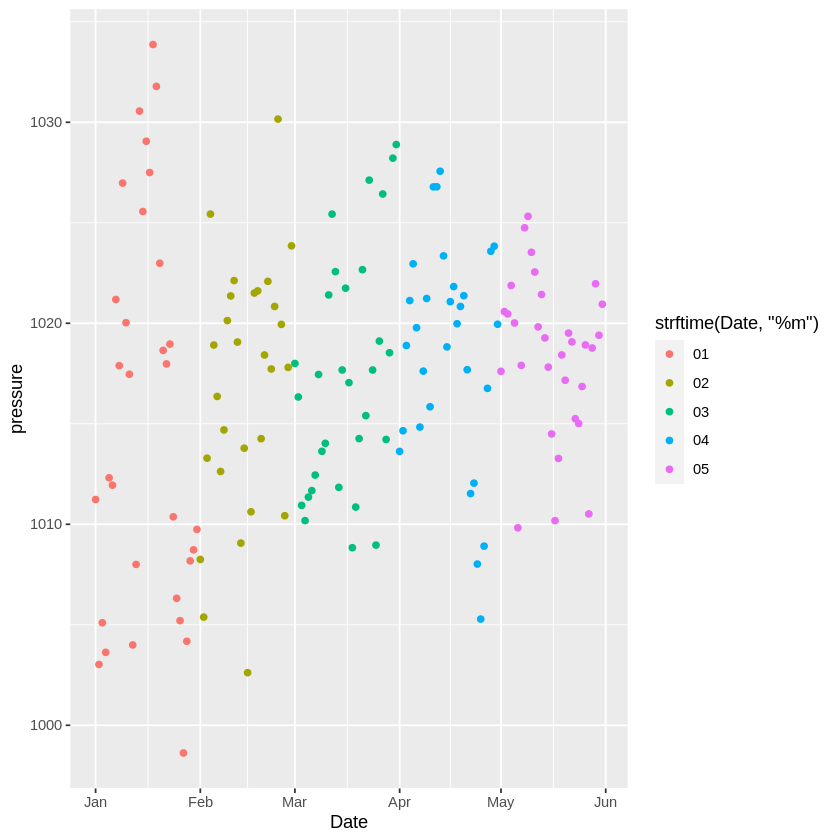

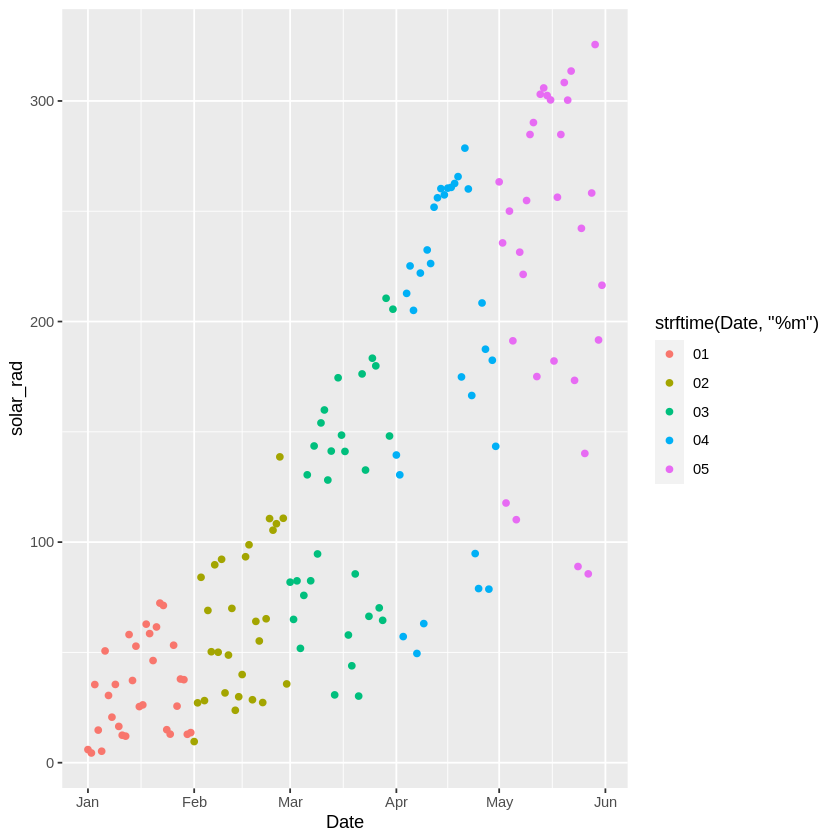

In [3]:
pressure_plot <- ggplot(weather, aes(x = Date, y = pressure, color = strftime(Date, '%m'))) +
                        geom_point()

solar_rad_plot <- ggplot(weather, aes(x = Date, y = solar_rad, color = strftime(Date, '%m'))) +
                        geom_point()

pressure_plot
solar_rad_plot

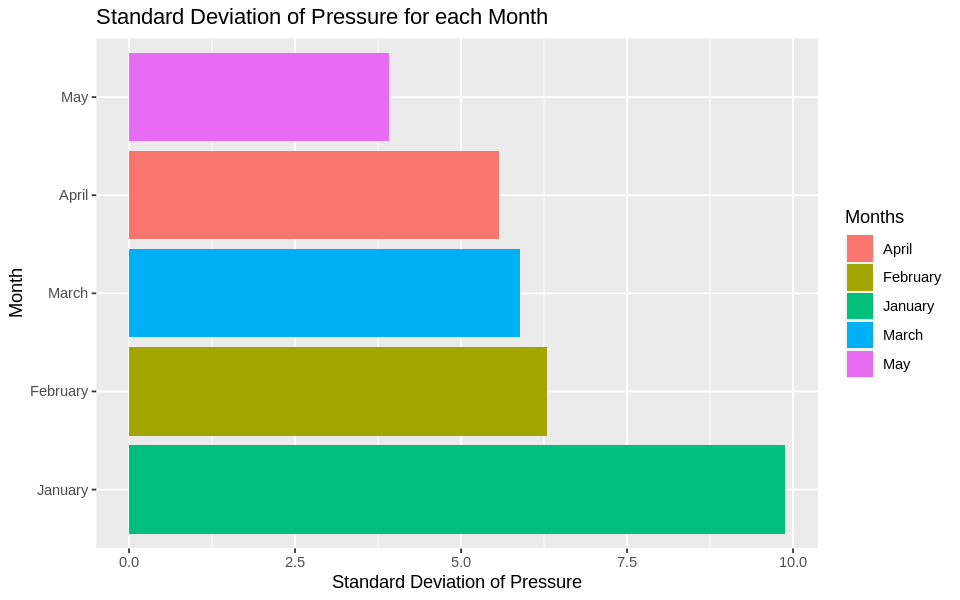

In [4]:
weather <- weather |>
           group_by(month) |>
           mutate(month = as_factor(month)) |> # month is the category
           mutate(STDev = sd(pressure)) |> # finds the standard deviation for pressure each month 
           mutate(mean_solar = mean(solar_rad))

standard_dev <- weather |>
           select(month, STDev) |> 
           distinct() # removes duplicate rows 

library(RColorBrewer)

# This plot shows how the spread of pressure values varies throughout the months
options(repr.plot.width = 8, repr.plot.height =5)
standard_dev_plot <- ggplot(standard_dev, aes(x = STDev, y = fct_reorder(month, STDev, .desc = TRUE),
                            fill = month)) +
                    geom_bar(stat = 'identity') +
                    labs(x = 'Standard Deviation of Pressure', y = 'Month', fill = 'Months', title = 'Standard Deviation of Pressure for each Month') +
                    theme(text = element_text(size = 17)) |>
                    scale_color_brewer(palette = 'Pastel1')
standard_dev_plot


In [5]:
# the knn model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
  set_engine("kknn") |>
  set_mode("classification")


# the centering and scaling recipe
weather_recipe <- recipe(month ~ mean_solar + STDev, data = weather) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_fit <- workflow() |>
    add_recipe(weather_recipe) |>
    add_model(knn_spec) |>
    fit(data = weather)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0
Best kernel: rectangular
Best k: 5

In [6]:
# the new observation to be classified:

new_obs <- read_csv('2019.csv')

names(new_obs)[names(new_obs) == "Time [UTC]"] <- "time" #renaming the column
names(new_obs)[names(new_obs) == "Hourly Precip [mm/hr]"] <- "precipitation" 
names(new_obs)[names(new_obs) == "Atmos Pressure [mb]"] <- "pressure" 
names(new_obs)[names(new_obs) == "Solar Rad [W/m^2]"] <- "solar_rad" 

new_obs <- mutate(new_obs, Date = as.Date(as.character(Date), #this turns the date integer into an actual date
                                               format = "%Y%m%d")) |>
           select(Date, solar_rad, pressure, precipitation) |># selecting the relevant columns 
           group_by(Date) |> 
           summarize(across(solar_rad:precipitation, mean, na.rm = TRUE)) |> # This finds the mean values for each day
           mutate(month = as.numeric(strftime(Date, '%m'))) |>
           filter(month == '1') 

new_obs$month[new_obs$month == '1'] <- 'January'
new_obs$month[new_obs$month == '2'] <- 'February'
new_obs$month[new_obs$month == '3'] <- 'March'
new_obs$month[new_obs$month == '4'] <- 'April'
new_obs$month[new_obs$month == '5'] <- 'May'

new_obs <- new_obs |>
        mutate(STDev = sd(pressure)) |>
        mutate(mean_solar = mean(solar_rad)) |>
        select(mean_solar, STDev) |>
        distinct()
new_obs

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 35040 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Time [UTC], Min Air Temp [deg C]
dbl (11): Date, Air Temp [deg C], Hourly Precip [mm/hr], Solar Rad [W/m^2], ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean_solar,STDev
<dbl>,<dbl>
38.77316,10.14488


In [7]:
# Predicting the month
predict(knn_fit, new_obs)

.pred_class
<fct>
January
